In [1]:
# UNDER CONSTRUCTION

import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import galsim
import cv2 as cv
from IPython import display
import tensorflow as tf
import tensorflow_probability as tfp

%matplotlib inline
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
dat = np.load('Cat-SFG-17-01-2020.npz')
dat.files

['nobj', 'listgal', 'flux1400sfg', 'sizesfg', 'randidx', 'e1', 'e2']

In [3]:
dat['listgal'].shape

(300, 96, 96)

In [4]:
img1 = np.abs(fits.open('psf2asec-96.psf.fits')[0].data[0,0,:,:])

### Loading PSF & SFG

In [5]:
gal = dat['listgal'][0,:,:]
psf = galsim.Image(img1, copy=True).array

psf /= np.sum(psf)

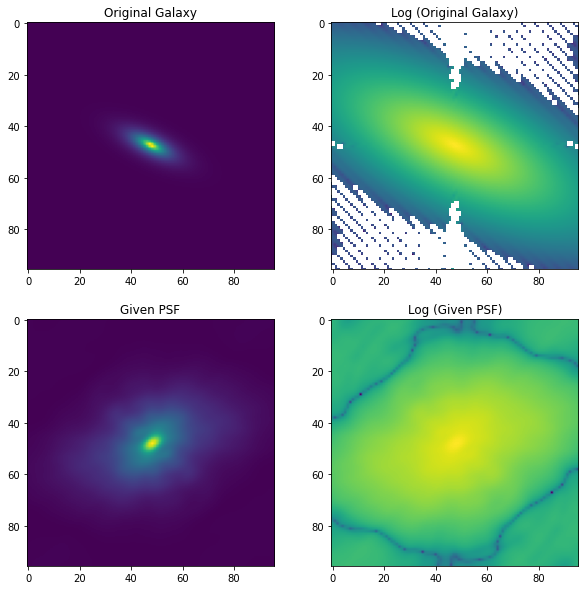

In [6]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10,10))
ax1.imshow(gal); ax1.set_title('Original Galaxy');
ax2.imshow(np.log10(gal)); ax2.set_title('Log (Original Galaxy)');
ax3.imshow(psf); ax3.set_title('Given PSF');
ax4.imshow(np.log10(psf)); ax4.set_title('Log (Given PSF)');

### FFT(Galaxy) + Gaussian Noise

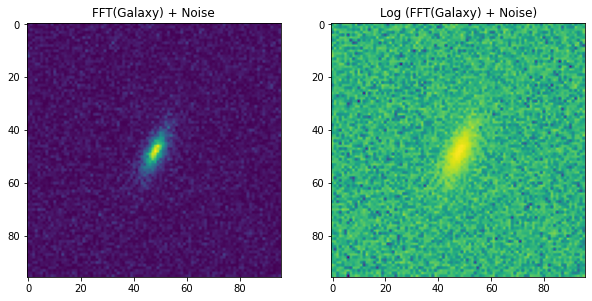

In [7]:
gal_fft = np.fft.fftshift(np.fft.fft2(gal))   
psf_fft = np.fft.fftshift(np.fft.fft2(psf))      

# SNR(x) = l2_norm(x)/sigma_noise 

SNR = 1.0e2                                                       # Signal to noise ratio in Fourier domain
sigma_noise = np.linalg.norm(gal_fft)/SNR                         # Standard deviation of noise

gal_fft_GSO = galsim.Image(gal_fft, copy=True)                    # Stored as GSO
gal_fft_GSO.addNoise(galsim.GaussianNoise(sigma = sigma_noise)) 

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,10))
ax1.imshow(np.abs(gal_fft_GSO.array)); ax1.set_title('FFT(Galaxy) + Noise');
ax2.imshow(np.log10(np.abs(gal_fft_GSO.array))); ax2.set_title('Log (FFT(Galaxy) + Noise)');

### Convolve with PSF

(0.06832032443786301, 0.06832032443786301)

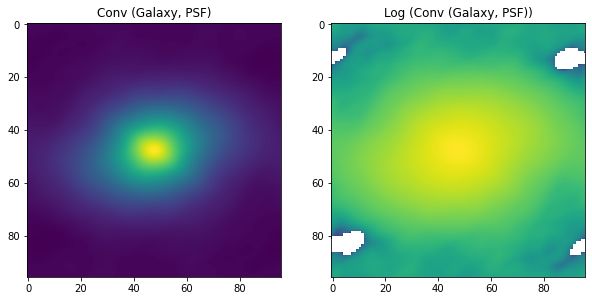

In [8]:
conv = np.multiply(gal_fft_GSO.array, psf_fft)

final_gal = np.real(np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(conv))))  # IFFT to get back to brightness domain
final_gal = final_gal * (np.sum(gal)/np.sum(final_gal))                     # Normalisation

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,10))
ax1.imshow(final_gal); ax1.set_title('Conv (Galaxy, PSF)');
ax2.imshow(np.log10(final_gal)); ax2.set_title('Log (Conv (Galaxy, PSF))');

np.sum(gal), np.sum(final_gal)

# ADMM in TensorFlow

In [9]:
# Convert arrays to tensors

gal_tf = tf.convert_to_tensor(gal, dtype='complex64')
final_gal_tf = tf.convert_to_tensor(final_gal, dtype='complex64')
psf_tf = tf.convert_to_tensor(psf, dtype='complex64')

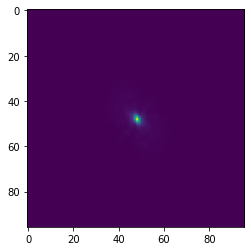

In [10]:
test = tf.signal.fftshift(tf.signal.fft2d(psf_tf))
plt.imshow(tf.math.abs(test))

In [11]:
# Utility Functions

def fftconvolve(image, kernel):

    x = tf.signal.fftshift(tf.signal.fft2d(image))
    y = tf.signal.fftshift(tf.signal.fft2d(kernel))

    return tf.math.real(tf.signal.fftshift(tf.signal.ifft2d(tf.signal.ifftshift(x * y))))


def fft(data):

    return tf.math.multiply( tf.math.divide(1, tf.math.sqrt(tf.convert_to_tensor(data.shape[0], dtype='complex64'))),  
                             tf.signal.fftshift(tf.signal.fft2d(tf.signal.ifftshift(data))) 
                           )


def ifft(data):

    return tf.math.multiply( tf.math.sqrt(tf.convert_to_tensor(data.shape[0], dtype='complex64')),
                             tf.signal.fftshift(tf.signal.ifft2d(tf.signal.ifftshift(data))) 
                           )


def soft_thresh(data, threshold):

    return tfp.math.soft_threshold(data, threshold)


def nmse(signal_1, signal_2):

    return tf.keras.losses.MSE(signal_1, signal_2)

In [12]:
# Projection - Enforce non-negative values
def proj(xi):
    
    return tf.math.maximum(xi,0)

 
def FISTA(tk, xk, x_rec, alpha, observation, psf, ST_lambda):

    x_temp = xk
    x_k1 = tf.math.subtract(x_rec, tf.math.multiply(alpha, grad(observation, x_rec, psf)))
    x_k1 = soft_thresh(x_k1, ST_lambda)
    xk = proj(x_k1)
    t_k1 = tf.math.add(1, tf.math.divide(tf.math.sqrt(tf.math.add(1, tf.math.multiply(4, tf.math.pow(tk, 2)))), 2))
    x_rec = tf.math.add(xk, tf.math.divide(tf.math.subtract(tk, 1), tf.math.multiply(t_k1, tf.math.subtract(xk - x_temp))) )
    tk = t_k1
    return x_rec, tk, xk


# H operator
def H(data, psf):
    
    return fftconvolve(data, psf)


# H transpose operator
def Ht(data, psf):
    
    return fftconvolve(data, tf.reverse(tf.reverse(psf, axis=[0]), axis=[1]))      # flip by 180


# The gradient
def grad(y, x_rec, psf):

    return ifft(Ht(H(fft(x_rec), psf) - y, psf))


# The cost function
def cost_func(y, x_rec, z, mu, rho, psf, reg_lambda, var=1.0):

    cost_val = tf.math.add(
               tf.math.subtract(
                    tf.math.multiply(tf.math.multiply(0.5, rho), tf.math.pow(tf.norm(tf.math.subtract(z-x_rec), 2))),
                    tf.tensordot(mu, tf.math.subtract(z-x_rec)) 
                                ),
                           tf.math.multiply(tf.math.divide(0.5/var), tf.norm(tf.math.subtract(y, tf.math.pow(H(fft(x_rec), psf), 2))))
                           )
    
    return cost_val




def runADMM(observation, first_guess, psf, grad, z_0, mu_0, rho_0, rho_max, eta, gamma, delta_0,
            reg_lambda, ST_lambda, n_iter, alpha=1.0):
    
    cost = []
    nmse_arr = np.zeros(n_iter)
    x_opt = np.zeros(observation.shape)
    count = 0
    
    # ADMM parameters
    x_k = first_guess
    z_k = z_0
    z_k1 = z_k
    mu_k = mu_0
    rho_k = rho_0         # Augmented lagrangian hyperparameter
    rho_k1 = rho_k
    delta_k = delta_0      
 
    # FISTA parameters
    tk = 1
    xk = first_guess
    
    
        
    for k in range(n_iter):
        
        # FISTA update
        x_rec, tk, xk = FISTA(tk, xk, x_k, alpha, observation, psf, ST_lambda)
        #x_rec, tk, xk = FISTA(xk, z_fista_old, z_k, tk, mu_k, alpha, observation, psf, ST_lambda, rho_k, sigma=1.0)
        
        # Denoising -- CHECK 
        z_k1 = tf.math.add(x_rec, tf.math.divide(mu_k, rho_k))
        #z_k1 = cv.GaussianBlur(np.abs(z_k1), (5,5), 0)      
        
        # mu update -- CHECK (Florent's version has the rho term - The paper does not)
        mu_k1 = tf.math.add(mu_k, tf.math.multiply(tf.math.subtract(x_rec, z_k1), rho_k))
    
        
        # Cost
        cost.append(cost_func(observation, x_rec, z_k1, mu_k1, rho_k, psf, reg_lambda))
        
        
        # Rho update
        delta_k1 = tf.math.multiply(tf.math.divide(1., final_gal.shape[0]),
                                    tf.math.add(tf.math.add(
                                                            tf.norm(tf.math.subtract(x_rec, x_k)), 
                                                            tf.norm(tf.math.subtract(z_k1, z_k))
                                                           ),
                                                tf.norm(tf.math.subtract(mu_k1, mu_k))
                                               )
                                   )
        
        if tf.math.greater_equal(delta_k1, tf.math.multiply(eta, delta_k)) and  tf.math.less(rho_k1, rho_max):
            rho_k1 = tf.math.multiply(gamma, rho_k)
        else:
            rho_k1 = rho_k  
        
        
        x_k = x_rec
        mu_k = mu_k1
        z_k = z_k1
        rho_k = rho_k1
                
        
        # Convert back to signal domain
        final_im = tf.math.abs(fft(x_rec))
        nmse_arr[k] = nmse(gal, final_im)
        
        
        if (k!=0) and (nmse_arr[k]<nmse_arr[k-1]) and count==0:
            x_opt = final_im
        elif (k!=0) and (nmse_arr[k]>nmse_arr[k-1]):
            count += 1
        
        
        if k%100==0 and k!=0:
            fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,16))
            ax1.imshow(final_im); ax1.set_title('Reconstruction after {} iterations'.format(k));
            ax2.imshow(tf.math.log(final_im)); ax2.set_title('Log Intensity Scale');
         
            ax3.plot(final_im[48,:], label='rec_im');
            ax3.plot(gal[48,:], label='gal'); 
            leg = ax3.legend()
            ax3.set_aspect(1.0/ax3.get_data_ratio()); ax3.set_title('Intensity Plot (Central Slice)')
            
            display.display(fig)
            display.clear_output(wait=True)
    
    return final_im, x_opt, nmse_arr, cost

In [13]:
n_iter = 600

# ADMM parameters (initial)
z_0 = 0; 
z_0 = tf.convert_to_tensor(z_0, dtype='complex64')

mu_0 = 0; 
mu_0 = tf.convert_to_tensor(mu_0, dtype='complex64')

rho_0 = 50          # Augmented lagrangian hyperparameter
rho_0  = tf.convert_to_tensor(rho_0, dtype='complex64')

rho_max = 200       # max rho value
rho_max  = tf.convert_to_tensor(rho_max, dtype='complex64')

eta = 0.5           # should be between - [0, 1)
eta  = tf.convert_to_tensor(eta, dtype='complex64')

gamma = 1.4         # multiplicative rho factor -- Should be > 1
gamma  = tf.convert_to_tensor(gamma, dtype='complex64')

delta_0 = 0
delta_0 = tf.convert_to_tensor(delta_0, dtype='complex64')


first_guess = tf.zeros(tf.shape(final_gal), tf.complex64)


# Deconvolve the image
final_im, x_opt, nmse_arr, cost = runADMM(final_gal, first_guess, psf, grad, z_0, mu_0, rho_0, rho_max, 
                                          eta, gamma, delta_0, reg_lambda=1e-4, ST_lambda=1e-9, n_iter=n_iter)


fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,16))
ax1.imshow(final_im); ax1.set_title('Final reconstruction after {} iterations'.format(n_iter));
ax2.imshow(tf.math.log(final_im)); ax2.set_title('Log Intensity Scale');

ax3.plot(final_im[48,:], label='rec_im');
ax3.plot(gal[48,:], label='gal'); 
leg = ax3.legend()
ax3.set_aspect(1.0/ax3.get_data_ratio()); ax3.set_title('Intensity Plot (Central Slice)')
plt.show(fig)

InvalidArgumentError: Value for attr 'Tcomplex' of float is not in the list of allowed values: complex64, complex128
	; NodeDef: {{node FFT2D}}; Op<name=FFT2D; signature=input:Tcomplex -> output:Tcomplex; attr=Tcomplex:type,default=DT_COMPLEX64,allowed=[DT_COMPLEX64, DT_COMPLEX128]> [Op:FFT2D]

In [ ]:
# Comparison

min_nmse = np.min(nmse_arr)
min_iter = np.where(nmse_arr == min_nmse)[0][0]

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,12))
ax1.imshow(x_opt); ax1.set_title('Optimal reconstruction: At {} iterations'.format(min_iter));
ax2.imshow(gal); ax2.set_title('Original Galaxy');
plt.show(fig)

fig2, ax3 = plt.subplots(1,1, figsize=(15,4))
ax3.plot(np.arange(1,n_iter+1), nmse_arr); ax3.set_title('NMSE vs. # Iterations');
plt.xlabel('Iterations')
plt.ylabel('NMSE')
plt.show(fig2)
print('\nMinimum NMSE = {} (at {} iterations)'.format(min_nmse, min_iter))